# Puma 560 - Square path for six-degrees-of-freedom manipulator for welding in car manufacturing

## Moran Garcia Daniel - Brunett Chavez Lex - Delgado Zambrano Jose - Trivino Gonzalez Hector

## 1. Implementation

### Import libraries

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
from math import *
from spatialmath import *
from spatialmath.base import *

### Trapezoidal and polynomial interpolation

In [2]:
# The following coordinates are the vertix of the square
A_coord = {"x": 0.3, "y": 0.15, "z": 0}
B_coord = {"x": 0.15, "y": 0.15, "z": 0}
C_coord = {"x": 0.15, "y": 0.3, "z": 0}
D_coord = {"x": 0.3, "y": 0.3, "z": 0}

STEPS = 20
STEP_SERIES = np.arange(0, STEPS * 4, 1) # STEPS times 4 due to working with 4 paths
puma = rtb.models.DH.Puma560()

In [3]:
def get_SE3_matrix(coordinates):
    return SE3(coordinates["x"], coordinates["y"], coordinates["z"])

def get_trap_path(c_A, c_B, int_type):
    path = {}
    if(len(c_A) == len(c_B)):
        for key in c_A:
            if(c_A[key] != c_B[key]):
                tp = []
                if int_type == "trap":
                    tp = rtb.lspb(c_A[key], c_B[key], STEPS)
                elif int_type == "poli":
                    tp = rtb.tpoly(c_A[key], c_B[key], STEPS)
                path[key] = tp
            else:
                path[key] = c_A[key]
    return path

def get_trj_coord(path):
    tj_dis = []
    tj_vel = []
    tj_acc = []
    for key in path:
        if isinstance(path[key], int) or isinstance(path[key], float):
            tj_dis.append(np.full((1, STEPS), path[key])[0])
            tj_vel.append(np.zeros(STEPS))
            tj_acc.append(np.zeros(STEPS))
        else:
            tj_dis.append(path[key].q)
            tj_vel.append(path[key].qd)
            tj_acc.append(path[key].qdd)
    tj_dis = np.array(tj_dis)
    tj_vel = np.array(tj_vel)
    tj_acc = np.array(tj_acc)
    return {"q": tj_dis.transpose(), "qd": tj_vel.transpose(), "qdd": tj_acc.transpose()}

def ikin_from_trj_coord(trj):
    inverse_kin_trj = []
    for ind_trj in trj:
        coord = {"x": ind_trj[0], "y": ind_trj[1], "z": ind_trj[2]}
        ikin = puma.ikine_min(get_SE3_matrix(coord))
        inverse_kin_trj.append(ikin.q)
    return np.array(inverse_kin_trj)

def get_ikin(coord_0, coord_1, int_type):
    path = get_trap_path(coord_0, coord_1, int_type)
    motion_traj = get_trj_coord(path)
    return ikin_from_trj_coord(motion_traj["q"])

def get_general_traj(int_type):
    ikin_trjAB = get_ikin(A_coord, B_coord, int_type)
    ikin_trjBC = get_ikin(B_coord, C_coord, int_type)
    ikin_trjCD = get_ikin(C_coord, D_coord, int_type)
    ikin_trjDA = get_ikin(D_coord, A_coord, int_type)

    ikin_trjAC = np.concatenate((ikin_trjAB, ikin_trjBC), axis=0)
    ikin_trjCA = np.concatenate((ikin_trjCD, ikin_trjDA), axis=0)
    return np.concatenate((ikin_trjAC, ikin_trjCA), axis=0)

def get_motion_traj(int_type):
    dis = []
    vel = []
    acc = []
    pathAB = get_trap_path(A_coord, B_coord, int_type)
    pathBC = get_trap_path(B_coord, C_coord, int_type)
    pathCD = get_trap_path(C_coord, D_coord, int_type)
    pathDA = get_trap_path(D_coord, A_coord, int_type)
    
    kin_traj_AB = get_trj_coord(pathAB)
    kin_traj_BC = get_trj_coord(pathBC)
    kin_traj_CD = get_trj_coord(pathCD)
    kin_traj_DA = get_trj_coord(pathDA)
    
    AC_dis = np.concatenate((kin_traj_AB["q"], kin_traj_BC["q"]), axis = 0)
    CA_dis = np.concatenate((kin_traj_CD["q"], kin_traj_DA["q"]), axis = 0)
    dis = np.concatenate((AC_dis, CA_dis), axis = 0)
    
    AC_vel = np.concatenate((kin_traj_AB["qd"], kin_traj_BC["qd"]), axis = 0)
    CA_vel = np.concatenate((kin_traj_CD["qd"], kin_traj_DA["qd"]), axis = 0)
    vel = np.concatenate((AC_vel, CA_vel), axis = 0)
    
    AC_acc = np.concatenate((kin_traj_AB["qdd"], kin_traj_BC["qdd"]), axis = 0)
    CA_acc = np.concatenate((kin_traj_CD["qdd"], kin_traj_DA["qdd"]), axis = 0)
    acc = np.concatenate((AC_acc, CA_acc), axis = 0)
    
    return {"q": dis, "qd": vel, "qdd": acc}

def get_title(kin_type, grph_type):
    title_type = ""
    if kin_type == "q":
        title_type = ("End effector cartesian " if grph_type == "cart" else "Joint ") + "position"
    elif kin_type == "qd":
        title_type = ("End effector cartesian " if grph_type == "cart" else "Joint ") + "velocity"
    else:
        title_type = ("End effector cartesian " if grph_type == "cart" else "Joint ") + "acceleration"
    return title_type

def get_labels(graph_type):
    if graph_type == "cart":
        return ["x", "y", "z"]
    elif graph_type == "joint":
        return ["q1", "q2", "q3", "q4", "q5", "q6"]
    return ""

def get_pic_route(k_type, grp_type):
    title = grp_type
    if k_type == "q":
        title += "_dis" 
    elif k_type == "qd":
        title += "_vel"
    elif k_type == "qdd":
        title += "_acc"
    return "../res/"+title + ".png"

def graph_motion_curve(series_trap_pol, series_sli, tr_ar, pl_ar, sli_ar, kin_type, graph_type):
    fig, axs = plt.subplots(3)
    title_type = get_title(kin_type, graph_type)
    labels = get_labels(graph_type)

    axs[0].set_title(title_type + " vs step (Polinomial Interpolation)")
    axs[1].set_title(title_type + " vs step (Trapezoidal Interpolation)")
    axs[2].set_title(title_type + " vs step (Screw Linear interpolation)")
    
    for i in range(len(labels)): # Analysis of Pol, Trap and Screw linear
        axs[0].plot(series_trap_pol, pl_ar[kin_type].transpose()[i], label=labels[i])
        axs[1].plot(series_trap_pol, tr_ar[kin_type].transpose()[i], label=labels[i])
        axs[2].plot(series_sli, sli_ar[kin_type].transpose()[i], label=labels[i])
    axs[0].legend(framealpha=1, frameon=True)
    axs[1].legend(framealpha=1, frameon=True)
    axs[2].legend(framealpha=1, frameon=True)
    
    plt.savefig(get_pic_route(kin_type, graph_type))
    fig.tight_layout()

### Screw linear interpolation

In [4]:
def concat_pos_quat(pos, quat):
    return np.concatenate((pos, quat), axis=None)

def J1_of_Q(Q):
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
    return np.array([[-q1, q0, q3, -q2],
                     [-q2, -q3, q0, q1],
                     [-q3, q2, -q1, q0]])

def get_ikin_from_SE3(SE3_mat):
    return puma.ikine_min(SE3_mat).q

def get_jacobian(SE3_mat):
    return puma.jacobe(get_ikin_from_SE3(SE3_mat))

def get_B_matrix(SE3_mat, Q_rep):
    p_hat = skew(SE3_mat.t)
    jacobian = get_jacobian(SE3_mat)
    inverse_mat = np.linalg.inv(np.matmul(jacobian, jacobian.transpose()))
    J1 = J1_of_Q(Q_rep)
    J01 = 2 * np.matmul(p_hat, J1)
    J11 = 2 * J1
    J2 = concatenate_J2(J01, J11)
    return np.matmul(np.matmul(jacobian.transpose(), inverse_mat), J2)

def concatenate_J2(m01, m11):
    I3 = np.identity(3)
    Z3 = np.zeros((3,3))
    up = np.concatenate((I3, m01), axis=1)
    down = np.concatenate((Z3, m11), axis=1)
    return np.concatenate((up, down), axis=0)

def get_theta(initial_SE3, final_SE3):
    # Step 1: Concat pos and quaternion
    initial_ikin = get_ikin_from_SE3(initial_SE3)
    pos = initial_SE3.t
    quat = r2q(initial_SE3.R)
    gamma = concat_pos_quat(pos, quat)
    
    # Step 2: Compute A(t+1), A = udq = Unit Dual Quaternion representation
    udq = UnitDualQuaternion(initial_SE3)
    c_udq = udq.conj()
    final_udq = UnitDualQuaternion(final_SE3)
    udq_i = udq * (c_udq * final_udq)

    # Step 3: Convert A(t+1) into gamma(t+1)
    SE3_i = udq_i.SE3()
    pos_i = SE3_i.t
    quat_i = r2q(SE3_i.R)
    gamma_i = concat_pos_quat(pos_i, quat_i)

    # Step 4: Compute theta(t+1)
    theta_i = initial_ikin + beta * np.matmul(get_B_matrix(initial_SE3, quat), gamma_i - gamma)
    
    return theta_i

def get_motion(initial_SE3, final_SE3):
    g_values = []
    theta_motion = []
    
    i = 0
    condition = True
    
    while condition:
        current_SE3 = []
        theta = []
        if i == 0:
            theta_i = get_theta(initial_SE3, final_SE3)
            current_SE3 = puma.fkine(q=theta_i)
        else:
            theta_i = get_theta(g_values[i-1], final_SE3)
            current_SE3 = puma.fkine(q=theta_i)
        [c_x, c_y, c_z] = current_SE3.t
        [d_x, d_y, d_z] = final_SE3.t

        condition = not (abs(c_x - d_x) < ERROR and abs(c_y - d_y) < ERROR and abs(c_z - d_z) < ERROR)
        g_values.append(current_SE3)
        theta_motion.append(theta_i)
        i = i+1
    return np.array(theta_motion), g_values

def get_steps(start, length):
    return np.arange(start, length)

def get_motion_array(g_values):
    motion = []
    for mat in g_values:
        motion.append(mat.t)
    return np.array(motion)

def concatenate_coord(g_values):
    traj = []
    time_series = []
    for i in range(len(g_values)):
        if i == 0:
            traj = get_motion_array(g_values[i])
            time_series = get_steps(0, len(g_values[i]))
        else:
            initial_time = time_series[len(time_series) - 1]
            steps = get_steps(initial_time + 1, initial_time + 1 + len(g_values[i]))
            time_series = np.concatenate((time_series, steps), axis = 0)
            traj = np.concatenate((traj, get_motion_array(g_values[i])), axis = 0)
    return np.array(traj), np.array(time_series)

def concatenate_motion(joint_motion):
    motion = []
    for i in range(len(joint_motion)):
        if i == 0:
            motion = joint_motion[i]
        else:
            motion = np.concatenate((motion, joint_motion[i]), axis = 0)
    return np.array(motion)

def get_vel_acc(coords):
    vel = []
    acc = []
    for i in range(len(coords)):
        if i == 0:
            vel = [np.zeros(len(coords[0]))] # Asuming initial vel and acc = 0
            acc = [np.zeros(len(coords[0]))]
        else:
            vel.append(coords[i] - coords[i-1])
            acc.append(vel[i] - vel[i-1])
    return np.array(vel), np.array(acc)

In [5]:
beta = 1/10
ERROR = 0.001

A_SE3 = get_SE3_matrix(A_coord)
B_SE3 = get_SE3_matrix(B_coord)
C_SE3 = get_SE3_matrix(C_coord)
D_SE3 = get_SE3_matrix(D_coord)

(joint_motion_AB, g_values_AB) = get_motion(A_SE3, B_SE3)
(joint_motion_BC, g_values_BC) = get_motion(B_SE3, C_SE3)
(joint_motion_CD, g_values_CD) = get_motion(C_SE3, D_SE3)
(joint_motion_DA, g_values_DA) = get_motion(D_SE3, A_SE3)

# Getting general trajectory, velocity and acceleration
(sli_trj, steps_sli) = concatenate_coord([g_values_AB, g_values_BC, g_values_CD, g_values_DA])
(vel, acc) = get_vel_acc(sli_trj)

## 2. Results

### Cartesian motion on end effector

In [6]:
sli_motion = {"q": sli_trj, "qd": vel, "qdd": acc}
trapezoidal_motion = get_motion_traj("trap")
polinomial_motion = get_motion_traj("poli")

<IPython.core.display.Javascript object>


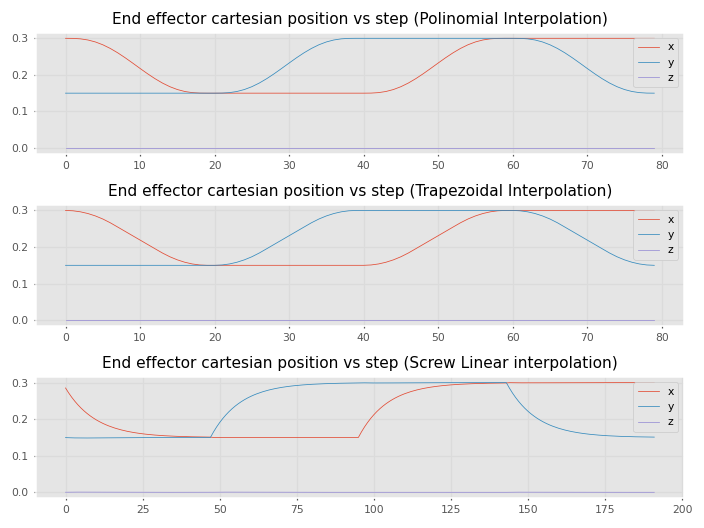

In [7]:
graph_motion_curve(STEP_SERIES, steps_sli, trapezoidal_motion, polinomial_motion, sli_motion, "q", "cart")

<IPython.core.display.Javascript object>


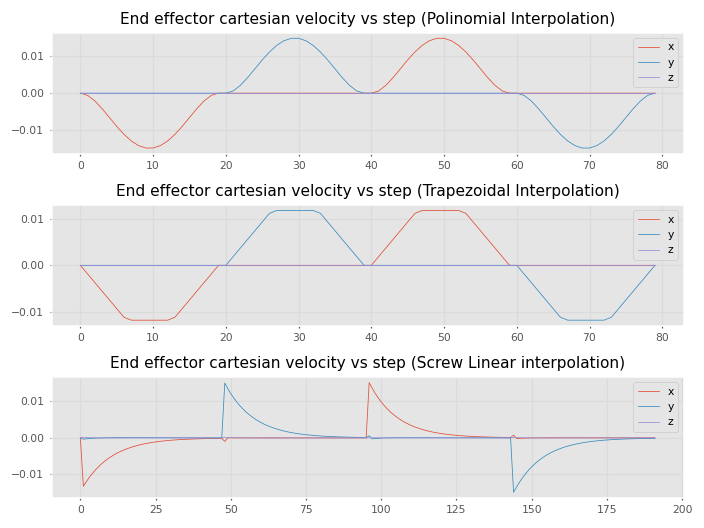

In [8]:
graph_motion_curve(STEP_SERIES, steps_sli, trapezoidal_motion, polinomial_motion, sli_motion, "qd", "cart")

<IPython.core.display.Javascript object>


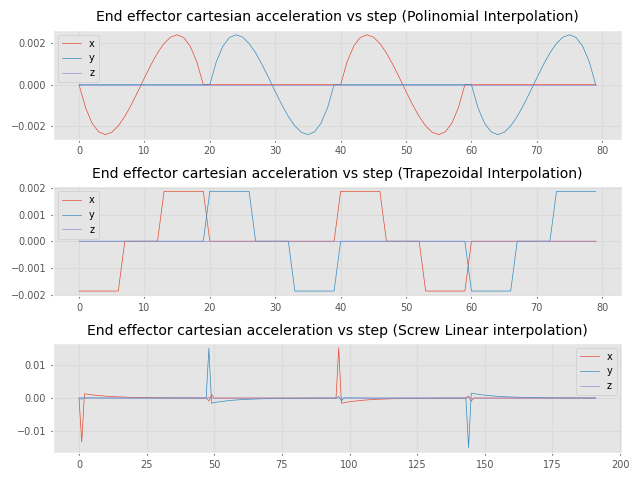

In [9]:
graph_motion_curve(STEP_SERIES, steps_sli, trapezoidal_motion, polinomial_motion, sli_motion, "qdd", "cart")

### Joint motion

In [10]:
trap_traj = get_general_traj("trap")
poli_traj = get_general_traj("poli")
sli_traj = concatenate_motion([joint_motion_AB, joint_motion_BC, joint_motion_CD, joint_motion_DA])

(trap_joint_vel, trap_joint_acc) = get_vel_acc(trap_traj)
(poli_joint_vel, poli_joint_acc) = get_vel_acc(poli_traj)
(sli_joint_vel, sli_joint_acc) = get_vel_acc(sli_traj)

trap_joint_motion = {"q": trap_traj, "qd": trap_joint_vel, "qdd": trap_joint_acc}
poli_joint_motion = {"q": poli_traj, "qd": poli_joint_vel, "qdd": poli_joint_acc}
sli_joint_motion = {"q": sli_traj, "qd": sli_joint_vel, "qdd": sli_joint_acc}

<IPython.core.display.Javascript object>


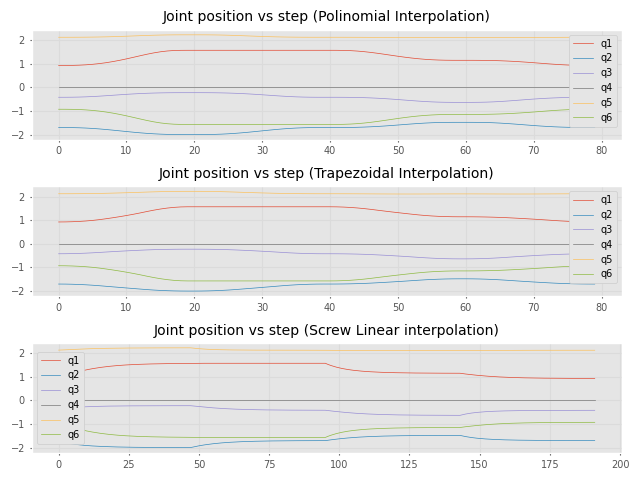

In [11]:
graph_motion_curve(STEP_SERIES, steps_sli, trap_joint_motion, poli_joint_motion, sli_joint_motion, "q", "joint")

<IPython.core.display.Javascript object>


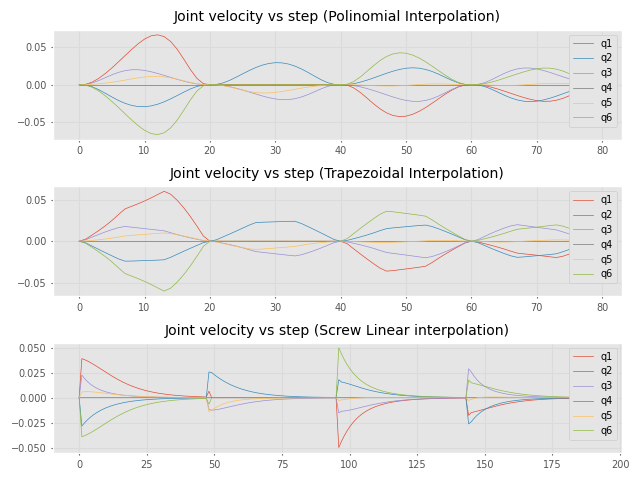

In [12]:
graph_motion_curve(STEP_SERIES, steps_sli, trap_joint_motion, poli_joint_motion, sli_joint_motion, "qd", "joint")

<IPython.core.display.Javascript object>


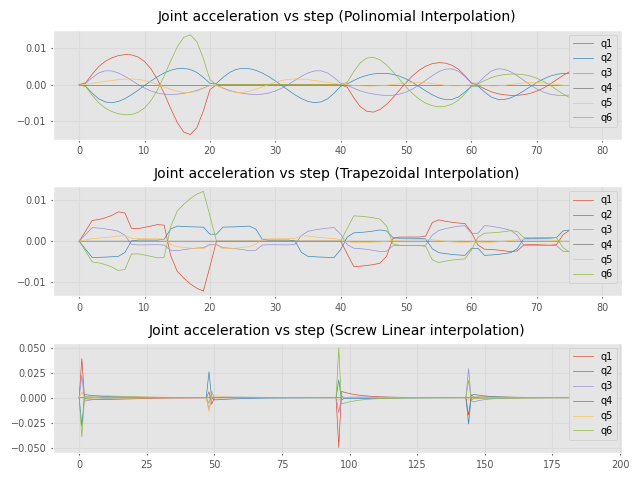

In [13]:
graph_motion_curve(STEP_SERIES, steps_sli, trap_joint_motion, poli_joint_motion, sli_joint_motion, "qdd", "joint")

## Trapezoidal interpolation path animation

### Trapezoidal interpolation path animation

<IPython.core.display.Javascript object>


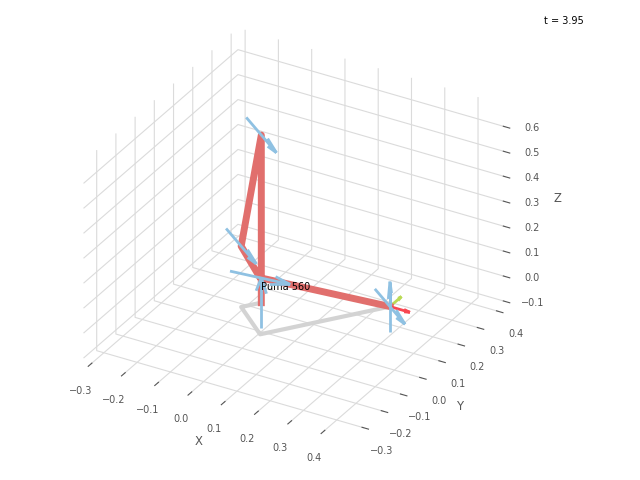

PyPlot3D backend, t = 3.999999999999994, scene:
  Puma 560

In [14]:
puma.plot(trap_traj, movie="../res/trapezoidal_path.gif")

### Polynomial interpolation path animation

<IPython.core.display.Javascript object>


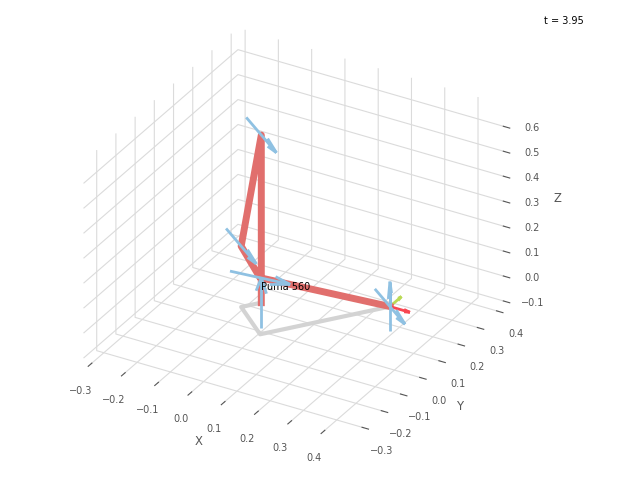

PyPlot3D backend, t = 3.999999999999994, scene:
  Puma 560

In [15]:
puma.plot(poli_traj, movie="../res/polinomial_path.gif")

### Screw Linear interpolation path animation

<IPython.core.display.Javascript object>


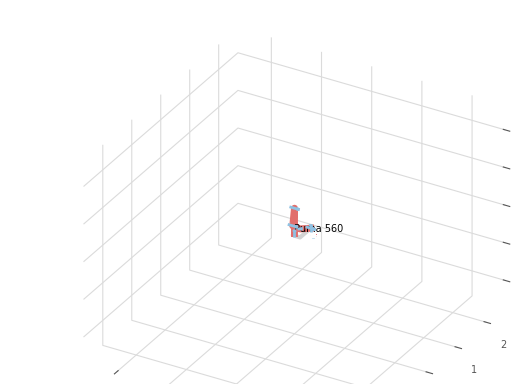

In [ ]:
puma.plot(sli_traj, movie="../res/screw_linear_int_path.gif")